`tensorflow-probability` is a library built on `tensorflow` for taking the awesome automatic differentiation / GPU computing abilities in Tensorflow and making them useful for probabilistic modeling for a range of models all the way from linear regression to variational autoencoders. Much of the functionality overlaps existing frameworks such as `stan`, `pymc3` and `pyro`, but there are some interesting new extensions as well. 

I'm going to use Tensorflow Probability to conduct Bayesian inference with the MNIST dataset for image inpainting as described in a [previous post](https://ckrapu.github.io/UQ-for-structured-data/). The primary steps involved in this workflow are:

* Defining a valid likelihood and prior distribution for the missing pixels

* Instantiating an MCMC sampler in `tfp`

* Running and interpreting the results

This notebook is relatively light on technical explanations - I want it to serve as a minimal example for using `tfp` in this type of application. Please contact me if you'd like more information!

The basic requirements are, obviously, `tensorflow` as well as `tensorflow-probability`. This example works with the 0.8.0 version of TFP.

In [30]:
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import time 
import matplotlib.pyplot as plt
tfd = tfp.distributions
tfp.__version__

'0.8.0-rc0'

I've prepared a pretrained generative model of MNIST digits which can generate samples of images. This specific Keras model is trained to map latent vectors drawn from a 50-dimensional unit Gaussian to 28 by 28 pixel images of MNIST digits.


In [26]:
model_path   = '../data/saved_models/vae_mnist_generative_net.h5'
generator  = tf.keras.models.load_model(model_path)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              809088    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0

In [13]:

test_path    = '../data/datasets/test/mnist_single.npy'
mcmc_kernel  = tfp.mcmc.HamiltonianMonteCarlo
mcmc_kwargs  = {}
n_chains     = 100


# Import models 
latent_dim = generator.input_shape[-1]
z_shape    = [n_chains, latent_dim]
shape_single_draw = [latent_dim]

# Import test data
test = np.load(test_path, allow_pickle=True)
x_true = test.data.repeat(n_chains,axis=0)
mask = (1 - test.mask).repeat(n_chains,axis=0)
#x_true = tf.cast(test.data,'float32')
#mask   = (1-test.mask)

# Prepare log prior function
prior_sd          = 1

ind = tfd.Independent(
    distribution=tfd.MultivariateNormalDiag(
        loc=tf.zeros(z_shape),
        scale_identity_multiplier=prior_sd))

log_prior = ind.log_prob


# Prepare log likelihood function
def log_like(z):
    x_pred = generator(z)
        
    raw_loss = tf.keras.losses.binary_crossentropy(x_true,
                                               x_pred,
                                               from_logits=True) 
    loss = tf.expand_dims(raw_loss,-1) * mask
    ll = tf.reduce_sum(loss,axis=[1,2,3])
    return ll
    
# Create target log density
def log_prob(z):
    return log_prior(z) + log_like(z)


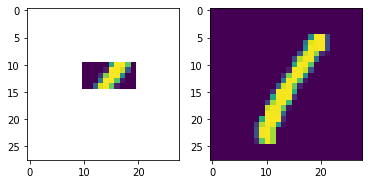

In [50]:
fig,axes = plt.subplots(1,2)
axes[0].imshow(test.squeeze())
axes[1].imshow(test.data.squeeze())

In [42]:
adaptive_hmc = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=log_prob,
        step_size=0.25)


In [43]:
# Run the chain (with burn-in).
@tf.function
def run_chain(kernel,n_samples,n_burnin):
  # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=n_samples,
      num_burnin_steps=n_burnin,
      current_state = np.random.randn(*z_shape).astype('float32'),
      kernel=kernel,
      parallel_iterations = n_chains,
    )

    return samples

### Short run

In [63]:
start = time.time()
num_results = 10000
num_burnin_steps = 5000
total_iter = num_results + num_burnin_steps
samples = run_chain(adaptive_hmc,num_results,num_burnin_steps)
end = time.time()
total = end - start
rate = total_iter/total
print(f'{rate} samples drawn per second.')

/home/jovyan/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


4.059700873153168 samples drawn per second.


In [64]:
sample_shape = [samples.shape[0],samples.shape[1],28,28,1]
sampled_x = np.zeros(sample_shape)

In [65]:
for i in range(sampled_x.shape[0]):
    sampled_x[i] = tf.math.sigmoid(generator(samples[i])).numpy()

In [66]:
from visualize import samples2gif
output_path = '../data/visualizations/hmc_chain.gif'
nrows, ncols = 10, 10
samples2gif(sampled_x[::20], output_path, nrows, ncols)

100%|██████████| 500/500 [00:21<00:00, 22.85it/s]


In [48]:
from IPython.display import HTML
HTML('<img src="../data/visualizations/hmc_chain.gif">')

In [61]:
import utils
replaced = utils.replace_batch_with_masked(test, sampled_x[-1])
replaced_flat = utils.flatten_image_batch(replaced.squeeze(), 10, 10)

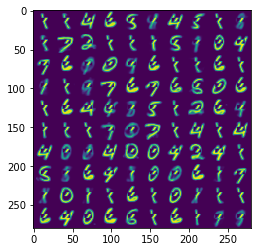

In [62]:
plt.imshow(replaced_flat)